## Exploración de los datos

### Importar librerías

In [10]:
import dendropy
from dendropy.interop import genbank

Se obtienen secuencias del brote de 2014

In [11]:
def get_ebov_2014_sources():
    # EBOV_2014
    # yield 'EBOV_2014', genbank.GenBankDna(id_range=(233036, 233118), prefix='KM')
    yield 'EBOV_2014', genbank.GenBankDna(id_range=(34549, 34563), prefix='KM0')



Se obtienen secuencias de otros brotes

In [12]:
def get_other_ebov_sources():
    # EBOV other
    yield 'EBOV_1976', genbank.GenBankDna(ids=['AF272001', 'KC242801'])
    yield 'EBOV_1995', genbank.GenBankDna(ids=['KC242796', 'KC242799'])
    yield 'EBOV_2007', genbank.GenBankDna(id_range=(84, 90), prefix='KC2427')



Se obtienen secuencias de otras especies de ebolavirus

In [13]:
def get_other_ebolavirus_sources():
    # BDBV
    yield 'BDBV', genbank.GenBankDna(id_range=(3, 6), prefix='KC54539')
    yield 'BDBV', genbank.GenBankDna(ids=['FJ217161'])

    # RESTV
    yield 'RESTV', genbank.GenBankDna(ids=['AB050936', 'JX477165', 'JX477166', 'FJ621583', 'FJ621584', 'FJ621585'])

    # SUDV
    yield 'SUDV', genbank.GenBankDna(ids=['KC242783', 'AY729654', 'EU338380',
                                          'JN638998', 'FJ968794', 'KC589025', 'JN638998'])
    # yield 'SUDV', genbank.GenBankDna(id_range=(89, 92), prefix='KC5453')

    # TAFV
    yield 'TAFV', genbank.GenBankDna(ids=['FJ217162'])


Se crean dos archivos, uno de ejemplo y uno auxiliar llamado other

In [14]:
other = open('other.fasta', 'w')
sampled = open('sample.fasta', 'w')

In [15]:
for species, recs in get_other_ebolavirus_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
                                         gb_to_taxon_fn=lambda gb: tn.require_taxon(
                                             label='%s_%s' % (species, gb.accession)))
    char_mat.write_to_stream(other, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')

Se generan los archivos correspondientes a los brotes de 2014 y 2007

In [16]:
other.close()
ebov_2014 = open('ebov_2014.fasta', 'w')
ebov = open('ebov.fasta', 'w')
for species, recs in get_ebov_2014_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
                                         gb_to_taxon_fn=lambda gb: tn.require_taxon(
                                             label='EBOV_2014_%s' % gb.accession))
    char_mat.write_to_stream(ebov_2014, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')
    char_mat.write_to_stream(ebov, 'fasta')
ebov_2014.close()

In [17]:
ebov_2007 = open('ebov_2007.fasta', 'w')
for species, recs in get_other_ebov_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
                                         gb_to_taxon_fn=lambda gb: tn.require_taxon(
                                             label='%s_%s' % (species, gb.accession)))
    char_mat.write_to_stream(ebov, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')
    if species == 'EBOV_2007':
        char_mat.write_to_stream(ebov_2007, 'fasta')

ebov.close()
ebov_2007.close()
sampled.close()

Ahora vamos a obtener las secuencias de los genes a partir de los archivos fasta

In [18]:
my_genes = ['NP', 'L', 'VP35', 'VP40']

In [19]:
def dump_genes(species, recs, g_dls, p_hdls):
    for rec in recs:

        for feature in rec.feature_table:
            if feature.key == 'CDS':
                gene_name = None
                for qual in feature.qualifiers:
                    if qual.name == 'gene':
                        if qual.value in my_genes:
                            gene_name = qual.value
                    elif qual.name == 'translation':
                        protein_translation = qual.value
                if gene_name is not None:
                    locs = feature.location.split('.')
                    start, end = int(locs[0]), int(locs[-1])
                    g_hdls[gene_name].write('>%s_%s\n' % (species, rec.accession))
                    p_hdls[gene_name].write('>%s_%s\n' % (species, rec.accession))
                    g_hdls[gene_name].write('%s\n' % rec.sequence_text[start - 1: end])
                    p_hdls[gene_name].write('%s\n' % protein_translation)

g_hdls = {}
p_hdls = {}

In [20]:
for gene in my_genes:
    g_hdls[gene] = open('%s.fasta' % gene, 'w')
    p_hdls[gene] = open('%s_P.fasta' % gene, 'w')
for species, recs in get_other_ebolavirus_sources():
    if species in ['RESTV', 'SUDV']:
        dump_genes(species, recs, g_hdls, p_hdls)
for gene in my_genes:
    g_hdls[gene].close()
    p_hdls[gene].close()

Ahora obtenemos una descripción de las secuencias. Primero definimos una función que nos permita obtener la descripción de las secuencias

In [21]:
def describe_seqs(seqs):
    print('Number of sequences: %d' % len(seqs.taxon_namespace))
    print('First 10 taxon sets: %s' % ' '.join([taxon.label for taxon in seqs.taxon_namespace[:10]]))
    lens = []
    for tax, seq in seqs.items():
        lens.append(len([x for x in seq.symbols_as_list() if x != '-']))
    print('Genome length: min %d, mean %.1f, max %d' % (min(lens), sum(lens) / len(lens), max(lens)))



In [22]:
ebov_seqs = dendropy.DnaCharacterMatrix.get_from_path('ebov.fasta', schema='fasta', data_type='dna')
print('EBOV')
describe_seqs(ebov_seqs)
del ebov_seqs


EBOV
Number of sequences: 26
First 10 taxon sets: EBOV_2014_KM034549 EBOV_2014_KM034550 EBOV_2014_KM034551 EBOV_2014_KM034552 EBOV_2014_KM034553 EBOV_2014_KM034554 EBOV_2014_KM034555 EBOV_2014_KM034556 EBOV_2014_KM034557 EBOV_2014_KM034558
Genome length: min 18700, mean 18925.2, max 18959


In [23]:
print('ebolavirus sequences')
ebolav_seqs = dendropy.DnaCharacterMatrix.get_from_path('other.fasta', schema='fasta', data_type='dna')
describe_seqs(ebolav_seqs)
from collections import defaultdict

species = defaultdict(int)
for taxon in ebolav_seqs.taxon_namespace:
    toks = taxon.label.split('_')
    my_species = toks[0]
    if my_species == 'EBOV':
        ident = '%s (%s)' % (my_species, toks[1])
    else:
        ident = my_species
    species[ident] += 1
for my_species, cnt in species.items():
    print("%20s: %d" % (my_species, cnt))
del ebolav_seqs


ebolavirus sequences
Number of sequences: 18
First 10 taxon sets: BDBV_KC545393 BDBV_KC545394 BDBV_KC545395 BDBV_KC545396 BDBV_FJ217161 RESTV_AB050936 RESTV_JX477165 RESTV_JX477166 RESTV_FJ621583 RESTV_FJ621584
Genome length: min 18796, mean 18892.7, max 18940
                BDBV: 5
               RESTV: 6
                SUDV: 6
                TAFV: 1


In [24]:
gene_length = {}
my_genes = ['NP', 'L', 'VP35', 'VP40']

for name in my_genes:
    gene_name = name.split('.')[0]
    seqs = dendropy.DnaCharacterMatrix.get_from_path('%s.fasta' % name, schema='fasta', data_type='dna')
    gene_length[gene_name] = []
    for tax, seq in seqs.items():
        gene_length[gene_name].append(len([x for x in seq.symbols_as_list() if x != '-']))
for gene, lens in gene_length.items():
    print('%6s: %d' % (gene, sum(lens) / len(lens)))

    NP: 2218
     L: 6636
  VP35: 990
  VP40: 988


## Alineamiento de secuencias

Para realizar el alineamiento, se requiere de herramientas como [MAFFT](https://mafft.cbrc.jp/alignment/software/),
[trimal](http://trimal.cgenomics.org/downloads) y
[MUSCLE 3.8](https://drive5.com/muscle/downloads_v3.htm).
Una vez descargadas, se debe agregar la ruta de los ejecutables al PATH del sistema operativo, o indicar las
configuraciones necesarias para que el programa pueda encontrarlos.

Importamos las librerías necesarias

In [25]:
import os
import time
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
from Bio.Align.Applications import MuscleCommandline
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

Utilizamos MAFFT para alinear las secuencias de los genes. La secuenciación puede tomar hasta varias horas, por lo
que para fines prácticos, se redujo la penalidad y el número de iteraciones, que pueden aumentarse, en caso de
requerirse mejores resultados.

In [61]:
start_time = time.time()

mafft_cline = MafftCommandline(cmd="C:\MAFFT\mafft.bat", input='sample.fasta', ep=0.234, maxiterate=20)
print(mafft_cline)
stdout, stderr = mafft_cline()
with open('align.fasta', 'w') as w:
    w.write(stdout)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, "segundos")
os.system('trimal -automated1 -in align.fasta -out trim.fasta -fasta')

C:\MAFFT\mafft.bat --maxiterate 20 --ep 0.234 sample.fasta
Tiempo de ejecución:  125.4500949382782 segundos


0

Se continúa con el alineamiento de las secuencias de proteínas

Definimos los genes

In [28]:
my_genes = ['NP', 'L', 'VP35', 'VP40']

In [35]:
for gene in my_genes:
    muscle_cline = MuscleCommandline( input='%s_P.fasta' % gene, out='%s_P_align.fasta' % gene)
    print(muscle_cline)
    muscle_cline()

muscle -in NP_P.fasta -out NP_P_align.fasta
muscle -in L_P.fasta -out L_P_align.fasta
muscle -in VP35_P.fasta -out VP35_P_align.fasta
muscle -in VP40_P.fasta -out VP40_P_align.fasta


De los archivos generados anteriormente, se obtienen las secuencias alineadas y se las guarda en nu nuevo archivo de
secuencia con un nuevo formato

In [38]:
for gene in my_genes:
    gene_seqs = {}
    unal_gene = SeqIO.parse('%s.fasta' % gene, 'fasta')
    for rec in unal_gene:
        gene_seqs[rec.id] = rec.seq

    al_prot = SeqIO.parse('%s_P_align.fasta' % gene, 'fasta')
    al_genes = []
    for protein in al_prot:
        my_id = protein.id
        seq = ''
        pos = 0
        for c in protein.seq:
            if c == '-':
                seq += '---'
            else:
                seq += str(gene_seqs[my_id][pos:pos + 3])
                pos += 3
        al_genes.append(SeqRecord(Seq(seq), id=my_id))
    print('%s: %d' % (gene, len(al_genes)))
    SeqIO.write(al_genes, '%s_align.fasta' % gene, 'fasta')

NP: 11
L: 11
VP35: 11
VP40: 11


## Reconstrucción filogenética

En este paso ya podemos generar un arbol, utilizando la herramienta [raxmlHPC](https://github.com/stamatak/standard-RAxML/tree/master/WindowsExecutables_v8.2.10)

Importamos las librerías necesarias

In [41]:
import dendropy
from dendropy.interop import raxml

Ahora reconstruimos el árbol, cabe recalcar que el proceso puede tomar varias horas, por lo que se recomienda
disminuir el número de secuencias a utilizar o el número de iteraciones.

In [42]:
start_time = time.time()
ebola_data = dendropy.DnaCharacterMatrix.get_from_path('trim.fasta', 'fasta')

rx = raxml.RaxmlRunner(raxml_path='C:\RAXMIHPC\\raxmlHPC.exe')
ebola_tree = rx.estimate_tree(ebola_data, raxml_args=['-m', 'GTRGAMMA', '-N', '3'])

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, "segundos")

Tiempo de ejecución:  262.98060369491577 segundos


In [43]:
print('El directorio temporal de RAxML: %s' % rx.working_dir_path)
del ebola_data

El directorio temporal de RAxML: C:\Users\pc\AppData\Local\Temp\tmpd4c26bx5


Generamos un archivo nexus con el árbol reconstruido

In [44]:
ebola_tree.write_to_path('my_ebola.nex', 'nexus')

A continuación, se muestra el árbol reconstruido utilizando librerías como Phylo o matplotlib

In [45]:
import matplotlib.pyplot as plt
from Bio import Phylo

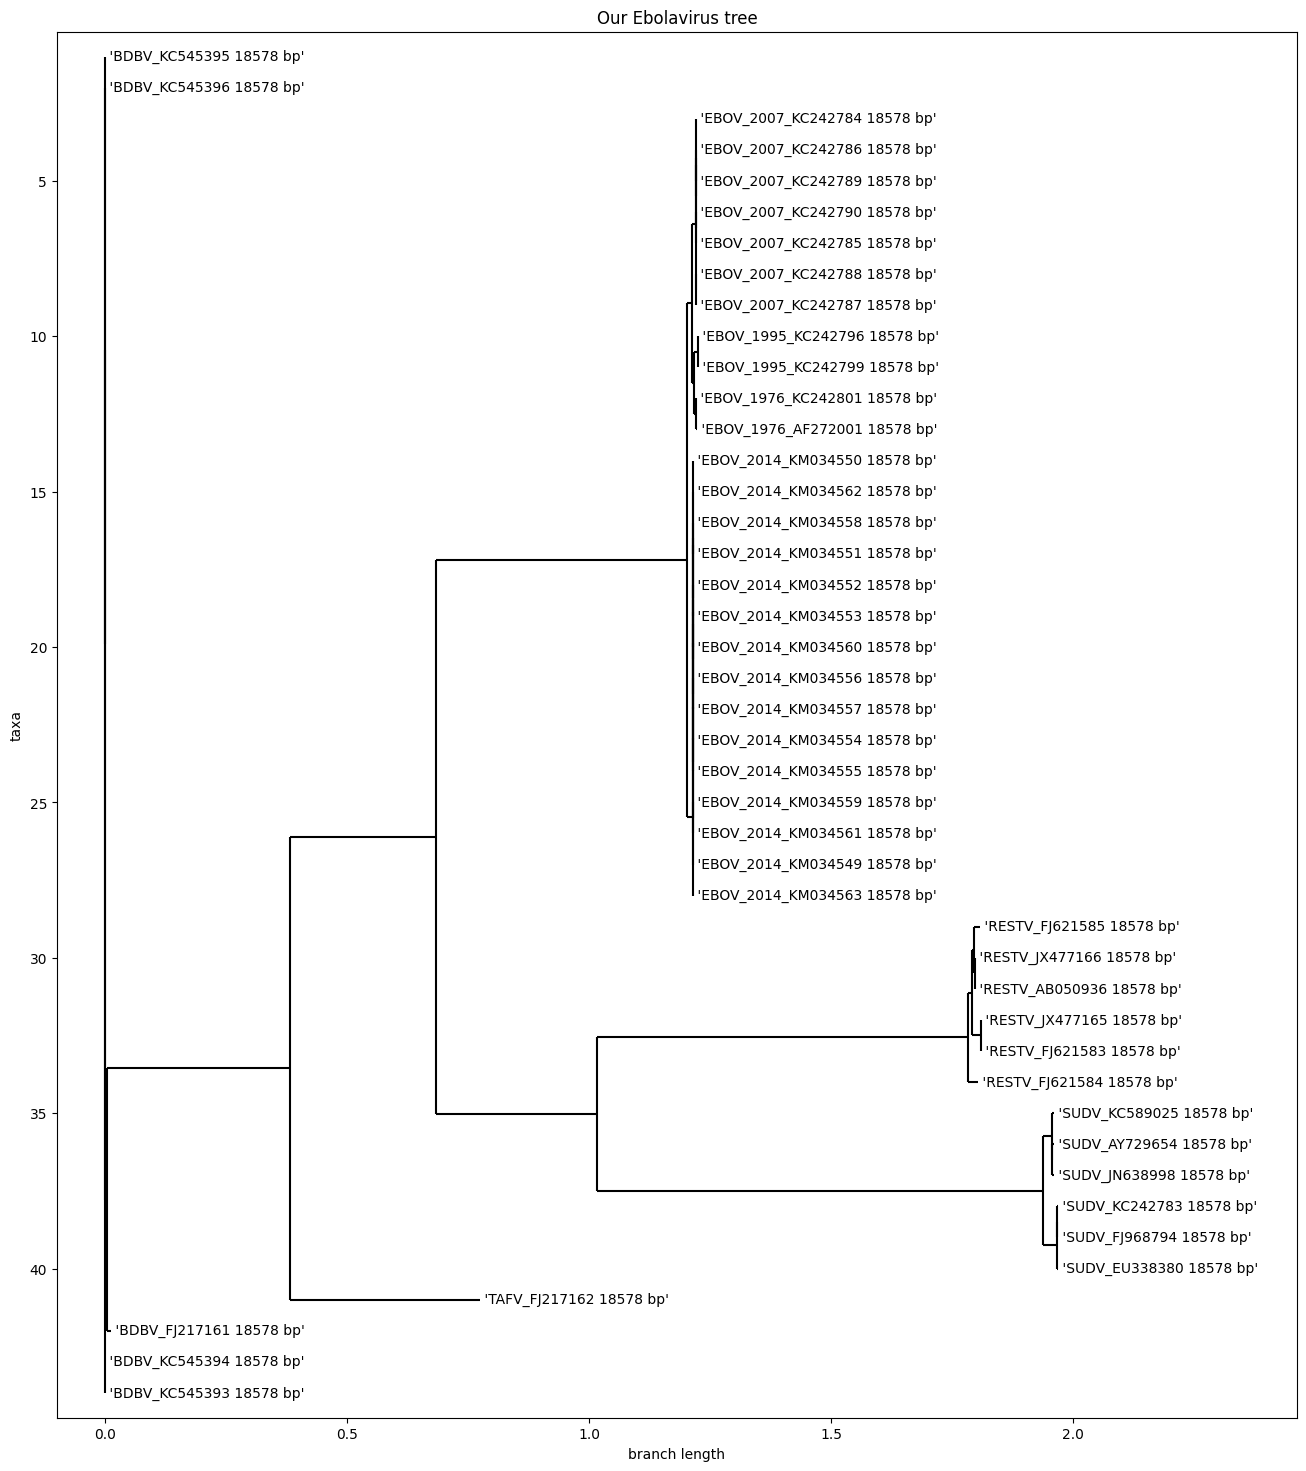

In [46]:
my_ebola_tree = Phylo.read('my_ebola.nex', 'nexus')
my_ebola_tree.name = 'Our Ebolavirus tree'

fig = plt.figure(figsize=(16, 18))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(my_ebola_tree, axes=ax)

## Manejo de árboles

Los árboles filogeneéticos pueden ser manipulados como estructuras de arbol, recorrindolos, obteniendo sus nodos,
alturas, etc.

Podemos definir una funcion para obtener el nivel del arbol a partir de un nodo

In [49]:
ebola_raxml = dendropy.Tree.get_from_path('my_ebola.nex', 'nexus')


In [50]:
def compute_level(node, level=0):
    for child in node.child_nodes():
        compute_level(child, level + 1)
    if node.taxon is not None:
        print("%s: %d %d" % (node.taxon, node.level(), level))


compute_level(ebola_raxml.seed_node)

'BDBV_KC545395 18578 bp': 2 2
'BDBV_KC545396 18578 bp': 3 3
'EBOV_2007_KC242784 18578 bp': 10 10
'EBOV_2007_KC242786 18578 bp': 12 12
'EBOV_2007_KC242789 18578 bp': 12 12
'EBOV_2007_KC242790 18578 bp': 12 12
'EBOV_2007_KC242785 18578 bp': 12 12
'EBOV_2007_KC242788 18578 bp': 10 10
'EBOV_2007_KC242787 18578 bp': 10 10
'EBOV_1995_KC242796 18578 bp': 10 10
'EBOV_1995_KC242799 18578 bp': 10 10
'EBOV_1976_KC242801 18578 bp': 10 10
'EBOV_1976_AF272001 18578 bp': 10 10
'EBOV_2014_KM034550 18578 bp': 10 10
'EBOV_2014_KM034562 18578 bp': 14 14
'EBOV_2014_KM034558 18578 bp': 16 16
'EBOV_2014_KM034551 18578 bp': 16 16
'EBOV_2014_KM034552 18578 bp': 18 18
'EBOV_2014_KM034553 18578 bp': 18 18
'EBOV_2014_KM034560 18578 bp': 17 17
'EBOV_2014_KM034556 18578 bp': 17 17
'EBOV_2014_KM034557 18578 bp': 17 17
'EBOV_2014_KM034554 18578 bp': 13 13
'EBOV_2014_KM034555 18578 bp': 12 12
'EBOV_2014_KM034559 18578 bp': 12 12
'EBOV_2014_KM034561 18578 bp': 12 12
'EBOV_2014_KM034549 18578 bp': 9 9
'EBOV_2014_KM0345

Podemos obtener la altura del árbol

In [51]:
def compute_height(node):
    children = node.child_nodes()
    if len(children) == 0:
        height = 0
    else:
        height = 1 + max(map(lambda x: compute_height(x), children))
    desc = node.taxon or 'Internal'
    print("%s: %d %d" % (desc, height, node.level()))
    return height


compute_height(ebola_raxml.seed_node)

'BDBV_KC545395 18578 bp': 0 2
'BDBV_KC545396 18578 bp': 0 3
'EBOV_2007_KC242784 18578 bp': 0 10
'EBOV_2007_KC242786 18578 bp': 0 12
'EBOV_2007_KC242789 18578 bp': 0 12
Internal: 1 11
'EBOV_2007_KC242790 18578 bp': 0 12
'EBOV_2007_KC242785 18578 bp': 0 12
Internal: 1 11
Internal: 2 10
Internal: 3 9
'EBOV_2007_KC242788 18578 bp': 0 10
'EBOV_2007_KC242787 18578 bp': 0 10
Internal: 1 9
Internal: 4 8
'EBOV_1995_KC242796 18578 bp': 0 10
'EBOV_1995_KC242799 18578 bp': 0 10
Internal: 1 9
'EBOV_1976_KC242801 18578 bp': 0 10
'EBOV_1976_AF272001 18578 bp': 0 10
Internal: 1 9
Internal: 2 8
Internal: 5 7
'EBOV_2014_KM034550 18578 bp': 0 10
'EBOV_2014_KM034562 18578 bp': 0 14
'EBOV_2014_KM034558 18578 bp': 0 16
'EBOV_2014_KM034551 18578 bp': 0 16
Internal: 1 15
'EBOV_2014_KM034552 18578 bp': 0 18
'EBOV_2014_KM034553 18578 bp': 0 18
Internal: 1 17
'EBOV_2014_KM034560 18578 bp': 0 17
Internal: 2 16
'EBOV_2014_KM034556 18578 bp': 0 17
'EBOV_2014_KM034557 18578 bp': 0 17
Internal: 1 16
Internal: 3 15
In

18

De manera recursiva, podemos obtener los nodos hijos del árbol

In [52]:
def compute_nofs(node):
    children = node.child_nodes()
    nofs = len(children)
    map(lambda x: compute_nofs(x), children)
    desc = node.taxon or 'Internal'
    print("%s: %d %d" % (desc, nofs, node.level()))


compute_nofs(ebola_raxml.seed_node)

Internal: 3 0


Podemos obtener los nodos hoja del árbol

In [53]:
def print_nodes(node):
    for child in node.child_nodes():
        print_nodes(child)
    if node.taxon is not None:
        print('%s (%d)' % (node.taxon, node.level()))


print_nodes(ebola_raxml.seed_node)


'BDBV_KC545395 18578 bp' (2)
'BDBV_KC545396 18578 bp' (3)
'EBOV_2007_KC242784 18578 bp' (10)
'EBOV_2007_KC242786 18578 bp' (12)
'EBOV_2007_KC242789 18578 bp' (12)
'EBOV_2007_KC242790 18578 bp' (12)
'EBOV_2007_KC242785 18578 bp' (12)
'EBOV_2007_KC242788 18578 bp' (10)
'EBOV_2007_KC242787 18578 bp' (10)
'EBOV_1995_KC242796 18578 bp' (10)
'EBOV_1995_KC242799 18578 bp' (10)
'EBOV_1976_KC242801 18578 bp' (10)
'EBOV_1976_AF272001 18578 bp' (10)
'EBOV_2014_KM034550 18578 bp' (10)
'EBOV_2014_KM034562 18578 bp' (14)
'EBOV_2014_KM034558 18578 bp' (16)
'EBOV_2014_KM034551 18578 bp' (16)
'EBOV_2014_KM034552 18578 bp' (18)
'EBOV_2014_KM034553 18578 bp' (18)
'EBOV_2014_KM034560 18578 bp' (17)
'EBOV_2014_KM034556 18578 bp' (17)
'EBOV_2014_KM034557 18578 bp' (17)
'EBOV_2014_KM034554 18578 bp' (13)
'EBOV_2014_KM034555 18578 bp' (12)
'EBOV_2014_KM034559 18578 bp' (12)
'EBOV_2014_KM034561 18578 bp' (12)
'EBOV_2014_KM034549 18578 bp' (9)
'EBOV_2014_KM034563 18578 bp' (8)
'RESTV_FJ621585 18578 bp' (10)
'RE

Podemos obtener la anchura del árbol

In [55]:
from collections import deque


def print_breadth(tree):
    queue = deque()
    queue.append(tree.seed_node)
    while len(queue) > 0:
        process_node = queue.popleft()
        if process_node.taxon is not None:
            print('%s (%d)' % (process_node.taxon, process_node.level()))
        else:
            for child in process_node.child_nodes():
                queue.append(child)

print_breadth(ebola_raxml)

'BDBV_KC545394 18578 bp' (1)
'BDBV_KC545393 18578 bp' (1)
'BDBV_KC545395 18578 bp' (2)
'BDBV_KC545396 18578 bp' (3)
'BDBV_FJ217161 18578 bp' (4)
'TAFV_FJ217162 18578 bp' (5)
'EBOV_2014_KM034563 18578 bp' (8)
'RESTV_FJ621584 18578 bp' (8)
'EBOV_2014_KM034549 18578 bp' (9)
'SUDV_KC589025 18578 bp' (9)
'SUDV_EU338380 18578 bp' (9)
'EBOV_2007_KC242784 18578 bp' (10)
'EBOV_2007_KC242788 18578 bp' (10)
'EBOV_2007_KC242787 18578 bp' (10)
'EBOV_1995_KC242796 18578 bp' (10)
'EBOV_1995_KC242799 18578 bp' (10)
'EBOV_1976_KC242801 18578 bp' (10)
'EBOV_1976_AF272001 18578 bp' (10)
'EBOV_2014_KM034550 18578 bp' (10)
'RESTV_FJ621585 18578 bp' (10)
'RESTV_JX477165 18578 bp' (10)
'RESTV_FJ621583 18578 bp' (10)
'SUDV_AY729654 18578 bp' (10)
'SUDV_JN638998 18578 bp' (10)
'SUDV_KC242783 18578 bp' (10)
'SUDV_FJ968794 18578 bp' (10)
'RESTV_JX477166 18578 bp' (11)
'RESTV_AB050936 18578 bp' (11)
'EBOV_2007_KC242786 18578 bp' (12)
'EBOV_2007_KC242789 18578 bp' (12)
'EBOV_2007_KC242790 18578 bp' (12)
'EBOV_2007

Podemos simplificar el árbol, eliminando los nodos internos que no aportan información

In [57]:
from copy import deepcopy

simple_ebola = deepcopy(ebola_raxml)
def simplify_tree(node):
    prefs = set()
    for leaf in node.leaf_nodes():
        my_toks = leaf.taxon.label.split(' ')[0].split('_')
        if my_toks[0] == 'EBOV':
            prefs.add('EBOV' + my_toks[1])
        else:
            prefs.add(my_toks[0])
    if len(prefs) == 1:
        print(prefs, len(node.leaf_nodes()))
        node.taxon = dendropy.Taxon(label=list(prefs)[0])
        # node.collapse_clade()
        node.set_child_nodes([])
    else:
        for child in node.child_nodes():
            simplify_tree(child)


simplify_tree(simple_ebola.seed_node)
simple_ebola.ladderize()
simple_ebola.write_to_path('ebola_simple.nex', 'nexus')

{'BDBV'} 1
{'BDBV'} 1
{'EBOV2007'} 7
{'EBOV1995'} 2
{'EBOV1976'} 2
{'EBOV2014'} 15
{'RESTV'} 6
{'SUDV'} 6
{'TAFV'} 1
{'BDBV'} 1
{'BDBV'} 1
{'BDBV'} 1


Utilizando estas librerías es posbible recrear el árbol con caracteres ASCII de la siguiente manera

Importamos las librerías necesarias

In [47]:
from copy import deepcopy
import matplotlib.pyplot as plt
from Bio import Phylo

Utilizando el archivo nexus generado anteriormente, se puede recrear el árbol con caracteres ASCII


In [58]:
ebola_tree = Phylo.read('my_ebola.nex', 'nexus')
ebola_tree.name = 'Ebolavirus tree'
ebola_simple_tree = Phylo.read('ebola_simple.nex', 'nexus')
ebola_simple_tree.name = 'Ebolavirus simplified tree'

Utilizamos la función para generar el árbol en ASCII

 , BDBV
 |
 | BDBV
_|
 , BDBV
 |
 , BDBV
 |
 , BDBV
 |
 |             ____________ TAFV
 |            |
 |____________|                      _________________________ RESTV
              |          ___________|
              |         |           |_______________________________ SUDV
              |_________|
                        |                 , EBOV2014
                        |_________________|
                                          , EBOV2007
                                          |
                                          |, EBOV1995
                                          ||
                                           | EBOV1976

 , 'BDBV_KC545395 18578 bp'
 |
 , 'BDBV_KC545396 18578 bp'
 |
 |                          , 'EBOV_2007_KC242784 18578 bp'
 |                          |
 |                          , 'EBOV_2007_KC242786 18578 bp'
 |                          |
 |                          | 'EBOV_2007_KC242789 18578 bp'
 |                          |
 |       

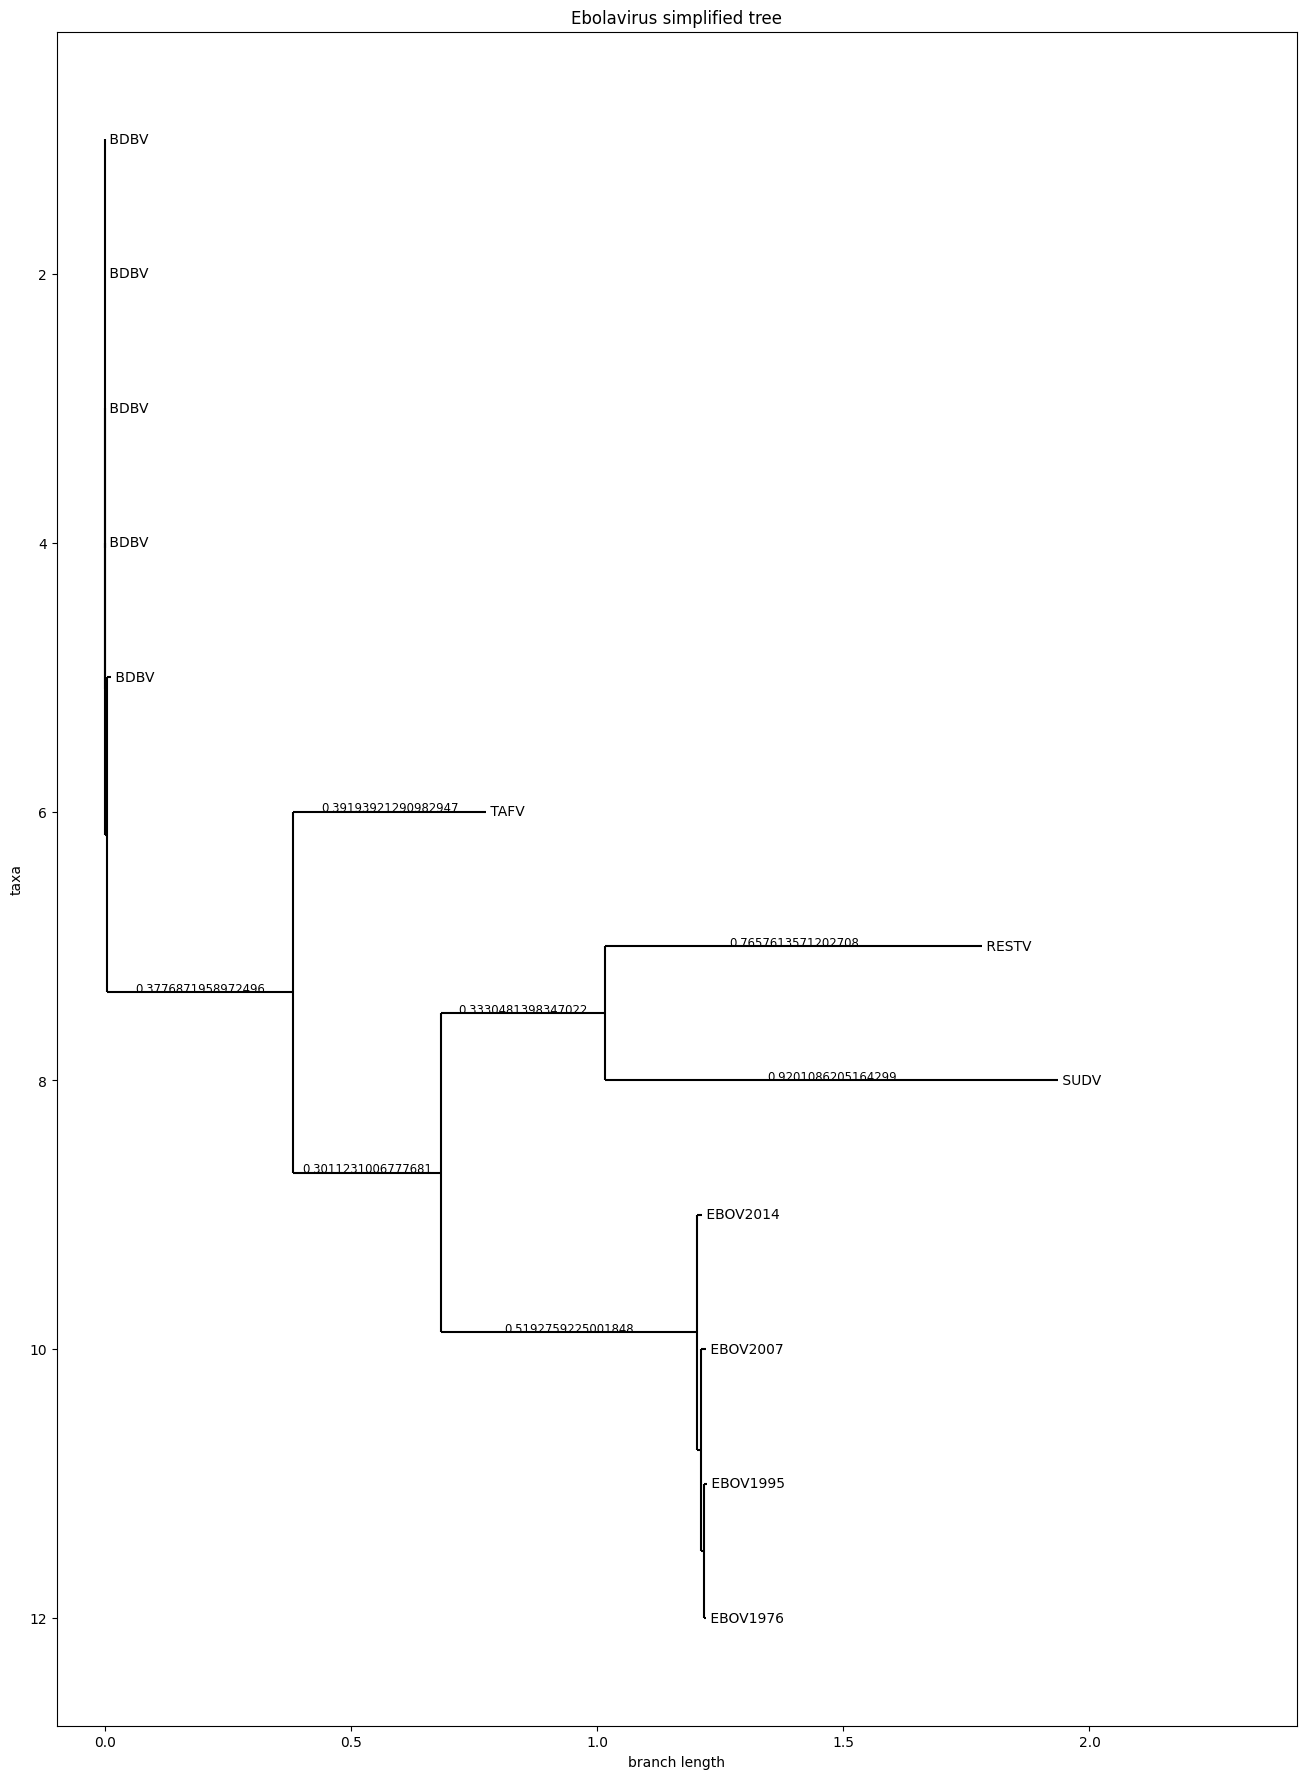

In [59]:
Phylo.draw_ascii(ebola_simple_tree)
Phylo.draw_ascii(ebola_tree)

fig = plt.figure(figsize=(16, 22))
ax = fig.add_subplot(111)
Phylo.draw(ebola_simple_tree, axes=ax, branch_labels=
           lambda c: c.branch_length if c.branch_length > 0.02 else None)


A continuación definimos funciones que nos permiten colorear el árbol de acuerdo a la especie, obteniendo una mejor
visualización del arbol en cuestión

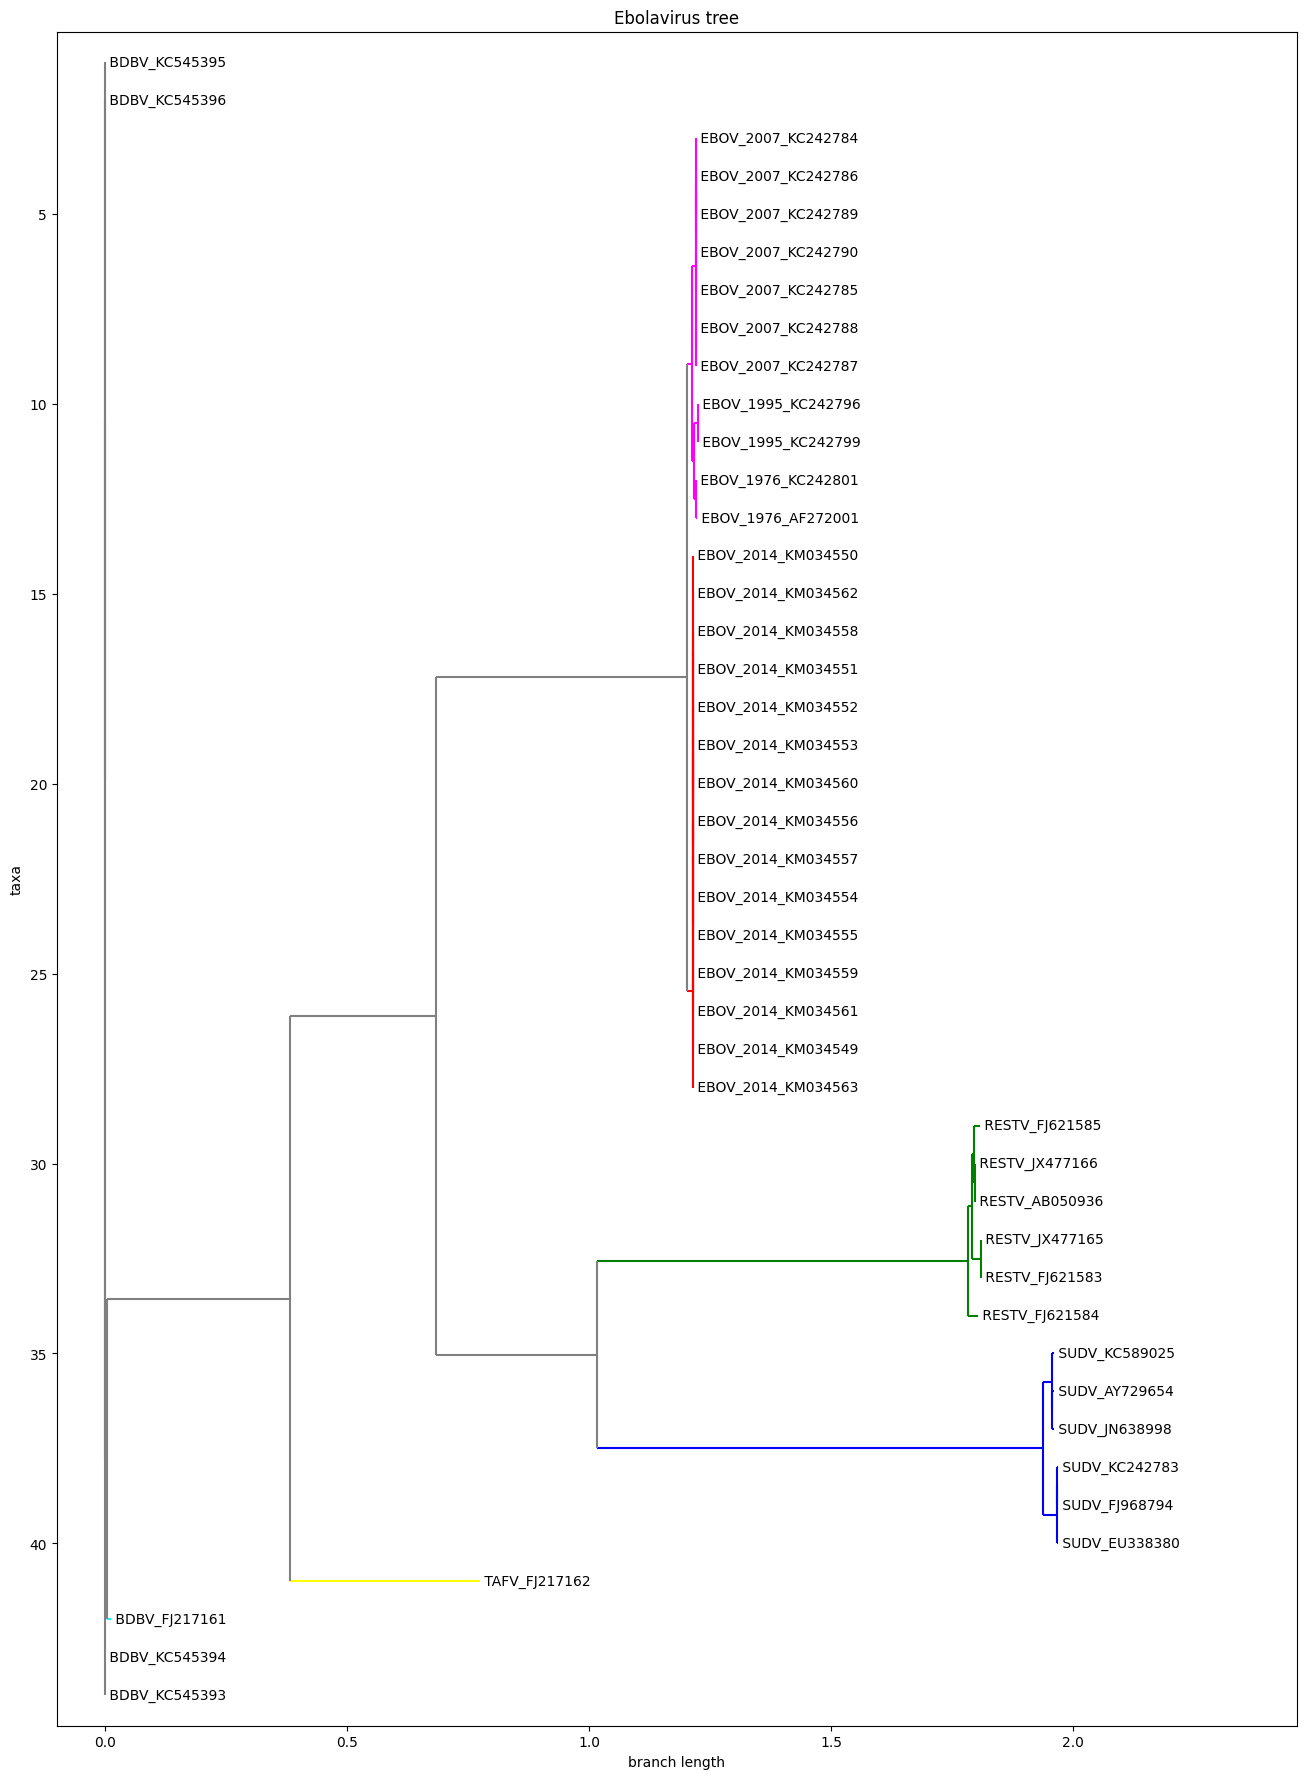

In [60]:
fig = plt.figure(figsize=(16, 22))
ax = fig.add_subplot(111)
from collections import OrderedDict
my_colors = OrderedDict({
'EBOV_2014': 'red',
'EBOV': 'magenta',
'BDBV': 'cyan',
'SUDV': 'blue',
'RESTV' : 'green',
'TAFV' : 'yellow'
})

def get_color(name):
    for pref, color in my_colors.items():
        if name.find(pref) > -1:
            return color
    return 'grey'

def color_tree(node, fun_color=get_color):
    if node.is_terminal():
        node.color = fun_color(node.name)
    else:
        my_children = set()
        for child in node.clades:
            color_tree(child, fun_color)
            my_children.add(child.color.to_hex())
        if len(my_children) == 1:
            node.color = child.color
        else:
            node.color = 'grey'

ebola_color_tree = deepcopy(ebola_tree)
color_tree(ebola_color_tree.root)
Phylo.draw(ebola_color_tree, axes=ax, label_func=
           lambda x: x.name.split(' ')[0][1:] if x.name is not None else None)